In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
import xml.etree.ElementTree as ET
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
from pprint import pprint
from voc_eval import parse_rec
from train_img_generator import TrainImageGenerator
from feature_generator import FeatureGenerator
from helper import sliding_window, show_images, convert

In [3]:
with open('datasets/ImageSets/train.txt', 'r') as train_text:
    train_image_indices = train_text.read().strip().split('\n')

training_annotation_path = 'datasets/Annotations/{}.xml'
training_annotations_dict = {
    'waldo': {},
    'wenda': {},
    'wizard': {}
}

for train_image_index in train_image_indices:
    annotation_path = training_annotation_path.format(train_image_index)
    for label in parse_rec(annotation_path):
        target = label['name']
        bbox = label['bbox']
        if train_image_index not in training_annotations_dict[target]:
            training_annotations_dict[target][train_image_index] = [bbox]
        else:
            training_annotations_dict[target][train_image_index].append(bbox)

In [ ]:
for target in training_annotations_dict.keys():
    training_image_generator = TrainImageGenerator(target, training_annotations_dict[target])
    training_image_generator.generate_training_images()

In [4]:
waldo_positive_images = []
waldo_negative_images = []

for positive_image in sorted(os.listdir(TrainImageGenerator.POSITIVE_TRAIN_IMG_DIR.format('waldo'))):
    img_path = os.path.join(TrainImageGenerator.POSITIVE_TRAIN_IMG_DIR.format('waldo'), positive_image)
    image = cv2.imread(img_path)
    waldo_positive_images.append(image)
    
for negative_image in sorted(os.listdir(TrainImageGenerator.NEGATIVE_TRAIN_IMG_DIR.format('waldo'))):
    img_path = os.path.join(TrainImageGenerator.NEGATIVE_TRAIN_IMG_DIR.format('waldo'), negative_image)
    image = cv2.imread(img_path)
    waldo_negative_images.append(image)

In [14]:
hog_feature_params_rgb = {
    'orientations': 9,
    'pixels_per_cell': (8,8),
    'cells_per_block': (2,2),
    'transform_sqrt': True,
    'visualize': True
}

hog_rgb_feature_generator = FeatureGenerator('rgb', hog_feature_params_rgb)

waldo_positive_features = []
waldo_negative_features = []

for positive_img in waldo_positive_images:
    waldo_positive_features.append(hog_rgb_feature_generator.generate_features(positive_img))
    
for negative_img in waldo_negative_images:
    waldo_negative_features.append(hog_rgb_feature_generator.generate_features(negative_img))

In [15]:
unscaled_x = np.vstack((waldo_positive_features, waldo_negative_features)).astype(np.float64)
scaler = StandardScaler().fit(unscaled_x)
x = scaler.transform(unscaled_x)
y = np.hstack((np.ones(len(waldo_positive_features)), np.zeros(len(waldo_negative_features))))

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = np.random.randint(1, 100))

In [16]:
svc = LinearSVC(max_iter=50000)
svc.fit(x_train, y_train)

0.9890295358649789


In [59]:
accuracy = svc.score(x_test, y_test)
print(accuracy)

0.9890295358649789


In [17]:
with open('datasets/ImageSets/val.txt', 'r') as val_text:
    val_image_indices = val_text.read().strip().split('\n')
    
val_images_path = ['datasets/JPEGImages/{}.jpg'.format(index) for index in val_image_indices]

frames_containing_waldo = []
for (x, y, frame) in sliding_window(first_image, 16, (32, 64)):
    frame_feature = hog_rgb_feature_generator.generate_features(frame)
    frame_feature = np.reshape(frame_feature, (1, -1))
    feature_rescaled = scaler.transform(frame_feature)
    if svc.predict(feature_rescaled) == 1:
        frames_containing_waldo.append(frame)

In [19]:
frames_containing_waldo = [convert(frame, dest_model='rgb') for frame in frames_containing_waldo]
print(len(frames_containing_waldo))
# for index, frame in enumerate(frames_containing_waldo):
#     cv2.imwrite('datasets/{}.jpg'.format(index), frame)

82


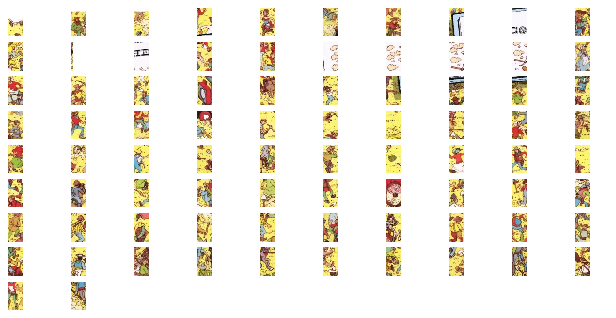

In [21]:
show_images(frames_containing_waldo, 10,9)

[0.1179672]


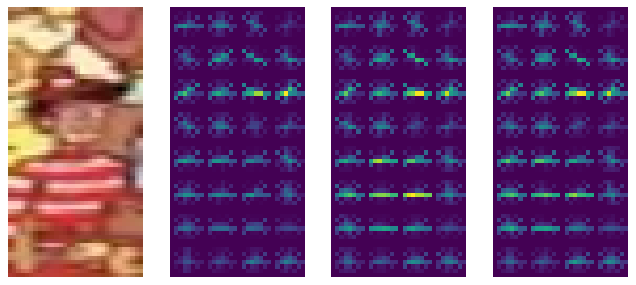

In [56]:
first_image = cv2.imread(val_images_path[0])
first_image_waldo = first_image[416:472, 296:312]
first_image_waldo = cv2.resize(first_image_waldo,(32,64),interpolation=cv2.INTER_CUBIC)
features = hog_rgb_feature_generator.generate_features(first_image_waldo)
rescaled_feature = scaler.transform(np.reshape(features, (1,-1)))
show_images(hog_rgb_feature_generator.visualize(), 4,1)
print(svc.decision_function(rescaled_feature))

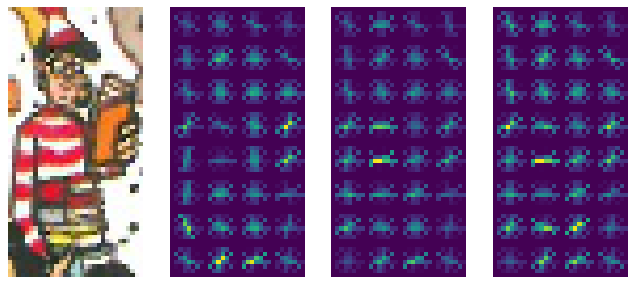

In [45]:
positive_img = waldo_positive_images[0]
waldo_positive_features.append(hog_rgb_feature_generator.generate_features(positive_img))
visual = hog_rgb_feature_generator.visualize()
show_images(visual, 4, 1)